Note: Data contains linestrings. Not sure how to convert them to polygons or h3 cells.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import keplergl
#from keplergl import KeplerGL
import matplotlib as plt
import plotly.express as px
import h3
import shapely
from geopandas import GeoDataFrame,GeoSeries
import folium
import matplotlib
%matplotlib inline

# Traffic Calming

Note: The original shapefile dataset did not have the geometry column in the appropriate format. The geojson file is extracted from the original shapefile by processing it through arcgis and converting the geometry to proper format.

In [2]:
#reading in data
traffic_calming = gpd.read_file('Traffic_Calming_Database.geojson')

In [152]:
#convert column names to lowercase
traffic_calming.columns = [s.strip().lower() for s in traffic_calming.columns]

In [153]:
traffic_calming.head()

fid  calm_id                 street         intersecti  \
0    1        1         Oakridge Drive         Brimley Rd   
1    2        3           Atlas Avenue   Gloucester Grove   
2    3        4         Balliol Street  Mt. Pleasant Road   
3    4        5        Balmoral Avenue        Avenue Road   
4    5        6  Bartlett Avenue North       Geary Avenue   

             intersec_1  spd_hump  traf_islan  spd_cush  installed  \
0            McCowan Rd         8           0         0       2004   
1  Eglinton Avenue West         2           0         0       1999   
2      Cleveland Street         2           0         0       1998   
3          Yonge Street         6           0         0       1998   
4        Davenport Road         6           0         0       1999   

                                            geometry  
0  LINESTRING (-79.24360 43.72610, -79.24305 43.7...  
1  LINESTRING (-79.43774 43.69668, -79.43815 43.6...  
2  LINESTRING (-79.38631 43.69940, -79.38182 43.7...  
3  LINESTRING (-79.39316 43.68589, -79.39378 43.6...  
4  LINESTRING (-79.43679 43.66998, -79.43697 43.6...

In [154]:
#looking at the map
traffic_calming.geometry.explore()

In [155]:
traffic_calming.columns

Index(['fid', 'calm_id', 'street', 'intersecti', 'intersec_1', 'spd_hump',
       'traf_islan', 'spd_cush', 'installed', 'geometry'],
      dtype='object')

In [156]:
#dropping unneccessary columns
traffic_calming = traffic_calming[['street','intersecti','spd_hump','traf_islan','spd_cush','geometry']]

In [157]:
#check to see if any rows are missing values for the geometry column
traffic_calming.loc[traffic_calming.geometry.isnull(), 'geometry']

684    None
Name: geometry, dtype: geometry

In [158]:
#check column
traffic_calming.iloc[684]

street         Kennedy Avenue
intersecti    Glenwood Avenue
spd_hump                    0
traf_islan                  2
spd_cush                    0
geometry                 None
Name: 684, dtype: object

In [159]:
#dropping rows that do not have a value for the geometry column
traffic_calming = traffic_calming.drop(traffic_calming[traffic_calming.geometry.isnull()].index)

In [160]:
#renaming column names
traffic_calming.rename(columns={'intersecti':'intersection','spd_hump':'speed_hump','traf_islan':'traffic_island','spd_cush':'speed_cushion'},inplace=True)

In [161]:
#extracting the latitude and longitude values from the geometry column

traffic_calming['latitude'] = traffic_calming.geometry.apply(lambda x: x.centroid.coords[0][1])
traffic_calming['longitude'] = traffic_calming.geometry.apply(lambda x: x.centroid.coords[0][0])

In [162]:
traffic_calming.head()

street       intersection  speed_hump  traffic_island  \
0         Oakridge Drive         Brimley Rd           8               0   
1           Atlas Avenue   Gloucester Grove           2               0   
2         Balliol Street  Mt. Pleasant Road           2               0   
3        Balmoral Avenue        Avenue Road           6               0   
4  Bartlett Avenue North       Geary Avenue           6               0   

   speed_cushion                                           geometry  \
0              0  LINESTRING (-79.24360 43.72610, -79.24305 43.7...   
1              0  LINESTRING (-79.43774 43.69668, -79.43815 43.6...   
2              0  LINESTRING (-79.38631 43.69940, -79.38182 43.7...   
3              0  LINESTRING (-79.39316 43.68589, -79.39378 43.6...   
4              0  LINESTRING (-79.43679 43.66998, -79.43697 43.6...   

    latitude  longitude  
0  43.729338 -79.239610  
1  43.697464 -79.438066  
2  43.700318 -79.381956  
3  43.685121 -79.396840  
4  43.671637 -79.437471

In [163]:
#combining latitude and longitudes to form coordinates column
traffic_calming['coordinates'] = traffic_calming.apply(lambda x: (x.latitude, x.longitude), axis=1)

In [164]:
#create hex cells for traffic calming

#create coordinate column
#pedestrian_crossover_exploded['coordinates'] = pedestrian_crossover_exploded['latitude'].astype('str') + ',' + pedestrian_crossover_exploded['longitude'].astype('str')

#then we define the function to get h3 hex cells from coordinates data
def get_hex_cell(coordinates):
    #a = float(coordinates.split(',')[0])
    #b = float(coordinates.split(',')[1])
    a = coordinates[0]
    b = coordinates[1]
    return h3.latlng_to_cell(a,b,res=10)

#finally, create a new column for hex cells by applying the function on coordinates column
traffic_calming['hex_cell'] = traffic_calming['coordinates'].apply(get_hex_cell)

In [165]:
traffic_calming.head()

street       intersection  speed_hump  traffic_island  \
0         Oakridge Drive         Brimley Rd           8               0   
1           Atlas Avenue   Gloucester Grove           2               0   
2         Balliol Street  Mt. Pleasant Road           2               0   
3        Balmoral Avenue        Avenue Road           6               0   
4  Bartlett Avenue North       Geary Avenue           6               0   

   speed_cushion                                           geometry  \
0              0  LINESTRING (-79.24360 43.72610, -79.24305 43.7...   
1              0  LINESTRING (-79.43774 43.69668, -79.43815 43.6...   
2              0  LINESTRING (-79.38631 43.69940, -79.38182 43.7...   
3              0  LINESTRING (-79.39316 43.68589, -79.39378 43.6...   
4              0  LINESTRING (-79.43679 43.66998, -79.43697 43.6...   

    latitude  longitude                               coordinates  \
0  43.729338 -79.239610    (43.72933805249128, -79.2396104322629)   
1  43.697464 -79.438066  (43.697464026265315, -79.43806550680002)   
2  43.700318 -79.381956   (43.70031786950201, -79.38195590020742)   
3  43.685121 -79.396840   (43.68512127713423, -79.39684043766181)   
4  43.671637 -79.437471     (43.67163690460497, -79.437471206031)   

          hex_cell  
0  8a2b9bd4c767fff  
1  8a2b9bc0d047fff  
2  8a2b9bc74777fff  
3  8a2b9bc7054ffff  
4  8a2b9bc54d1ffff

In [269]:
traffic_calming.to_csv('traffic_calming_h3.csv')

# Centreline Lanes

Note: The original shapefile dataset did not have the geometry column in the appropriate format. The geojson file is extracted from the original shapefile by processing it through arcgis and converting the geometry to proper format.

In [158]:
#reading in data
lanes = gpd.read_file('Centreline_Lanes.geojson')

In [159]:
#convert column names to lowercase
lanes.columns = [s.strip().lower() for s in lanes.columns]

In [160]:
lanes.head()

fid  objectid   geo_id               lf_name  mar13rc201      mar13rc2_1  \
0    1       501   913864     F G GARDINER XY W      201100      Expressway   
1    2      2001   911641  CENTENNIAL PARK BLVD      201400       Collector   
2    3      1001   911233        BELVEDERE BLVD      201500           Local   
3    4         1  7585679     LAKE SHORE BLVD W      201200  Major Arterial   
4    5       502   913875     F G GARDINER XY E      201100      Expressway   

   mar13rc2_2       mar13rc2_3 mar13rc2_4 section_id  gis_route  length  \
0      201110  City Expressway       CITY     200-20     100019  1221.8   
1      201400        Collector       CITY     012203      60431   850.0   
2      201500            Local       CITY     310200      60201   488.0   
3      201200   Major Arterial       CITY     002-21     100710  1832.0   
4      201110  City Expressway       CITY     200-50     100043  1609.2   

  networkcla structuret  numberofla  width     fromstreet  \
0   Pavement     Street           3   16.0     WICKMAN RD   
1   Pavement     Street           4   27.6    RATHBURN RD   
2   Pavement     Street           2    8.5  ROYAL YORK RD   
3   Pavement     Street           4   19.5    KIPLING AVE   
4   Pavement     Street           3   16.0    KIPLING AVE   

                tostreet  shape_leng  \
0          THE EAST MALL  330.462878   
1  [850 m N] RATHBURN RD  390.888582   
2          MONTGOMERY RD  133.386946   
3           BROWN'S LINE  135.053958   
4          THE EAST MALL  322.426099   

                                            geometry  
0  LINESTRING (-79.54521 43.61462, -79.54518 43.6...  
1  LINESTRING (-79.59005 43.64550, -79.59019 43.6...  
2  LINESTRING (-79.51511 43.65010, -79.51669 43.6...  
3  LINESTRING (-79.53400 43.59435, -79.53560 43.5...  
4  LINESTRING (-79.54509 43.61445, -79.54501 43.6...

In [161]:
#drop unneccesary columns
lanes = lanes[['lf_name','mar13rc2_3','numberofla','geometry']]

In [162]:
#renaming columns
lanes = lanes.rename(columns={'lf_name':'road_name','mar13rc2_3':'road_class','numberofla':'number_of_lanes','width':'width'})

In [163]:
lanes.head()

road_name       road_class  number_of_lanes  \
0     F G GARDINER XY W  City Expressway                3   
1  CENTENNIAL PARK BLVD        Collector                4   
2        BELVEDERE BLVD            Local                2   
3     LAKE SHORE BLVD W   Major Arterial                4   
4     F G GARDINER XY E  City Expressway                3   

                                            geometry  
0  LINESTRING (-79.54521 43.61462, -79.54518 43.6...  
1  LINESTRING (-79.59005 43.64550, -79.59019 43.6...  
2  LINESTRING (-79.51511 43.65010, -79.51669 43.6...  
3  LINESTRING (-79.53400 43.59435, -79.53560 43.5...  
4  LINESTRING (-79.54509 43.61445, -79.54501 43.6...

In [164]:
#check to see if any rows are missing values for the geometry column
#no geometry column values are missing
lanes.loc[lanes.geometry.isnull(), 'geometry'].count()

0

In [165]:
lanes.describe()

number_of_lanes
count     49451.000000
mean          1.910477
std           1.331600
min           0.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           6.000000

There are some values where number of lanes 0. These will have to be treated.

### Treating Number of Lanes

<AxesSubplot:>

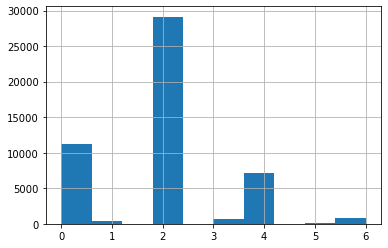

In [166]:
#histogram of lanes
lanes.number_of_lanes.hist()

In [167]:
#looking at which types of lanes have number of lanes = 0
lanes.loc[lanes['number_of_lanes']==0].explore()

In [168]:
#looking at the count of lanes with number of lanes = 0 by road classficiation
lanes.loc[lanes['number_of_lanes']==0].road_class.value_counts()

Laneway                       3612
Other                         1765
Local                         1463
Provincial Expressway         1037
Provincial Expressway Ramp     995
Pending                        609
Major Arterial                 560
Collector                      472
Minor Arterial                 292
Park Road                      110
City Expressway                 81
City Expressway Ramp            45
Unassumed Laneway               37
Major Arterial Ramp             35
Private Laneway                 27
Other Ramp                      12
Remove                          10
Collector Ramp                  10
Reserved Bus Lane                9
Undedicated Laneway              3
Private Walkway                  3
Name: road_class, dtype: int64

Looking at the map of rows where lane = 0, it is evident that these are roads where there is no lane markings on the road (e.g. local residential roads) or provincial highways.. These can be classified as 1 lane instead.

In [169]:
lanes.road_class.unique()

array(['City Expressway', 'Collector', 'Local', 'Major Arterial',
       'Minor Arterial', 'Provincial Expressway Ramp',
       'Provincial Expressway', 'Laneway', 'Other', 'Major Arterial Ramp',
       'Pending', 'Collector Ramp', 'City Expressway Ramp',
       'Undedicated Laneway', 'Private Laneway', 'Park Road',
       'Unassumed Laneway', 'Remove', 'Private Walkway', 'Other Ramp',
       'Minor Arterial Ramp', 'Reserved Bus Lane'], dtype=object)

<AxesSubplot:>

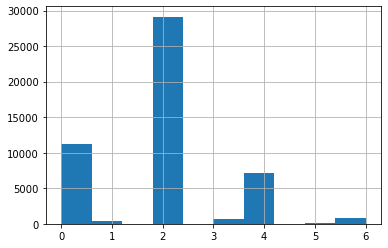

In [170]:
lanes.number_of_lanes.hist()

In [171]:
#if road_class is on the list and number of lanes = 0, replace number of lanes with 1
road_class_list = ['Laneway','Other','Local','Provincial Expressway Ramp','City Expressway Ramp','Unassumed Laneway','Private Laneway','Park Road','Pending','Provincial Expressway']

lanes.loc[(lanes['road_class'].isin(road_class_list)) & (lanes['number_of_lanes']==0),'number_of_lanes'] = 1

In [172]:
lanes.head()

road_name       road_class  number_of_lanes  \
0     F G GARDINER XY W  City Expressway                3   
1  CENTENNIAL PARK BLVD        Collector                4   
2        BELVEDERE BLVD            Local                2   
3     LAKE SHORE BLVD W   Major Arterial                4   
4     F G GARDINER XY E  City Expressway                3   

                                            geometry  
0  LINESTRING (-79.54521 43.61462, -79.54518 43.6...  
1  LINESTRING (-79.59005 43.64550, -79.59019 43.6...  
2  LINESTRING (-79.51511 43.65010, -79.51669 43.6...  
3  LINESTRING (-79.53400 43.59435, -79.53560 43.5...  
4  LINESTRING (-79.54509 43.61445, -79.54501 43.6...

<AxesSubplot:>

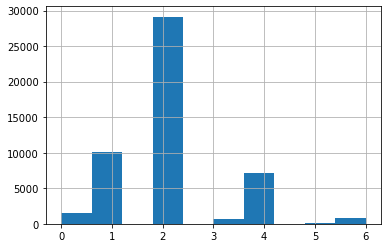

In [173]:
#looking at histogram of lanes after replacement
lanes.number_of_lanes.hist()

In [174]:
#looking at which types of lanes have number of lanes = 0
#most of the lanes with number of lanes = 0 are highways. these can be imputed with 4
lanes.loc[lanes['number_of_lanes']==0].explore()

In [175]:
road_class_list_2 = ['City Expressway','Major Arterial Ramp','Minor Arterial Ramp','Major Arterial']

lanes.loc[(lanes['road_class'].isin(road_class_list_2)) & (lanes['number_of_lanes']==0),'number_of_lanes'] = 4

<AxesSubplot:>

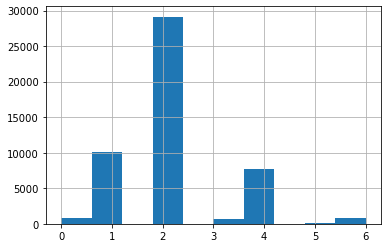

In [176]:
lanes.number_of_lanes.hist()

In [177]:
#extracting the latitude and longitude values from the geometry column

lanes['latitude'] = lanes.geometry.apply(lambda x: x.centroid.coords[0][1])
lanes['longitude'] = lanes.geometry.apply(lambda x: x.centroid.coords[0][0])

In [266]:
#create hex cells for traffic calming

#combining latitude and longitudes to form coordinates column
lanes['coordinates'] = lanes.apply(lambda x: (x.latitude, x.longitude), axis=1)

#then we define the function to get h3 hex cells from coordinates data
def get_hex_cell(coordinates):
    #a = float(coordinates.split(',')[0])
    #b = float(coordinates.split(',')[1])
    a = coordinates[0]
    b = coordinates[1]
    return h3.latlng_to_cell(a,b,res=10)

#finally, create a new column for hex cells by applying the function on coordinates column
lanes['hex_cell'] = lanes['coordinates'].apply(get_hex_cell)

In [267]:
#check processed dataframe
lanes.head()

road_name       road_class  number_of_lanes  \
0     F G GARDINER XY W  City Expressway                3   
1  CENTENNIAL PARK BLVD        Collector                4   
2        BELVEDERE BLVD            Local                2   
3     LAKE SHORE BLVD W   Major Arterial                4   
4     F G GARDINER XY E  City Expressway                3   

                                            geometry   latitude  longitude  \
0  LINESTRING (-79.54521 43.61462, -79.54518 43.6...  43.614866 -79.543195   
1  LINESTRING (-79.59005 43.64550, -79.59019 43.6...  43.645709 -79.592376   
2  LINESTRING (-79.51511 43.65010, -79.51669 43.6...  43.649931 -79.515899   
3  LINESTRING (-79.53400 43.59435, -79.53560 43.5...  43.594168 -79.534800   
4  LINESTRING (-79.54509 43.61445, -79.54501 43.6...  43.614689 -79.543117   

                                coordinates         hex_cell  
0   (43.61486562507038, -79.54319476367739)  8a2b9bcc5b1ffff  
1  (43.645709129544116, -79.59237555608563)  8a2b9bcf13b7fff  
2    (43.6499313838278, -79.51589930651804)  8a2b9bce0a47fff  
3   (43.59416802122274, -79.53480022451609)  8a2b9bcea047fff  
4  (43.614689378445405, -79.54311696042761)  8a2b9bcc5b1ffff

In [268]:
lanes.to_csv('lanes_h3.csv')